# Robotics, Vision & Control 3e: for Python
## Chapter 3: Time and Motion

Copyright (c) 2021- Peter Corke

In [1]:
try:
    from google.colab import output
    print('Running on CoLab')
    output.enable_custom_widget_manager()
    !pip install ipympl
    !pip install spatialmath-python
    !pip install roboticstoolbox-python>=1.0.2
    !pip install --no-deps rvc3python
    COLAB = True

except ModuleNotFoundError:
    COLAB = False

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

from IPython.display import HTML
import urllib.request

# add RTB examples folder to the path
import sys, os.path
import roboticstoolbox as rtb
import RVC3
# sys.path.append(os.path.join(rtb.__path__[0], 'examples'))
sys.path.append(os.path.join(RVC3.__path__[0], 'examples'))

# standard imports
import numpy as np
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from spatialmath import *
from spatialmath.base import *
from roboticstoolbox import quintic, trapezoidal, mtraj, mstraj, xplot, ctraj
%matplotlib widget
import matplotlib.pyplot as plt

There are some minor code changes compared to the book. These are to support 
the Matplotlib widget (ipympl) backend.  This allows 3D plots to be rotated
so the changes are worthwhile.

# 3.1 Time-Varying Pose


## 3.1.3 Transforming Spatial Velocities


In [2]:
aTb = SE3.Tx(-2) * SE3.Rz(-pi/2) * SE3.Rx(pi/2);

In [3]:
bV = [1, 2, 3, 4, 5, 6];

In [4]:
aJb = aTb.jacob();
aJb.shape
aV = aJb @ bV

array([      -3,       -1,        2,       -6,       -4,        5])

In [5]:
aV = aTb.Ad() @ [1, 2, 3, 0, 0, 0]

array([      -3,       -1,        2,        0,        0,        0])

In [6]:
aV = aTb.Ad() @ [0, 0, 0, 1, 0, 0]

array([       0,        0,        2,        0,       -1,        0])

In [7]:
aV = aTb.Ad() @ [1, 2, 3, 1, 0, 0]

array([      -3,       -1,        4,        0,       -1,        0])

## 3.1.4 Incremental Rotation


In [8]:
rotx(0.001)

array([[       1,        0,        0],
       [       0,        1,   -0.001],
       [       0,    0.001,        1]])

In [9]:
import time
Rexact = np.eye(3); Rapprox = np.eye(3);  # null rotation
w = np.array([1, 0, 0]);   # rotation of 1rad/s about x-axis
dt = 0.01;                 # time step
t0 = time.process_time();
for i in range(100):  # exact integration over 100 time steps
  Rexact = Rexact @ trexp(skew(w*dt));  # update by composition
print(time.process_time() - t0)

t0 = time.process_time();
for i in range(100):  # approximate integration over 100 time steps
  Rapprox = Rapprox + Rapprox @ skew(w*dt);  # update by addition
print(time.process_time() - t0)

0.004300202000000031
0.0008676939999996414


In [10]:
np.linalg.det(Rapprox) - 1

0.010049662092876055

In [11]:
np.linalg.det(Rexact) - 1

-2.55351295663786e-15

In [12]:
tr2angvec(trnorm(Rexact))

(0.9999999999999999, array([       1,        0,        0]))

In [13]:
tr2angvec(trnorm(Rapprox))

(0.999966668666524, array([       1,        0,        0]))

# 3.2 Accelerating Bodies and Reference Frames


## 3.2.1 Dynamics of Moving Bodies


In [14]:
J = np.array([[ 2, -1, 0],
              [-1,  4, 0],
              [ 0,  0, 3]]);
orientation = UnitQuaternion();  # identity quaternion
w = 0.2 * np.array([1, 2, 2]);

In [15]:
dt = 0.05;  # time step
def update():
  global orientation, w
  for t in np.arange(0, 10, dt):
     wd = -np.linalg.inv(J) @ (np.cross(w, J @ w))  # (3.12)
     w += wd * dt
     orientation *= UnitQuaternion.EulerVec(w * dt)
     yield orientation.R

# tranimate(update(), dim=1.5);
plotvol3(new=True)
HTML(tranimate(update(), dim=1.5, movie=True))

## 3.2.2 Transforming Forces and Torques


In [16]:
bW = [1, 2, 3, 0, 0, 0];

In [17]:
aW = aTb.inv().Ad().T @ bW

array([      -3,       -1,        2,        0,        4,        2])

# 3.3 Creating Time-Varying Pose


## 3.3.1 Smooth One-Dimensional Trajectories


In [18]:
traj = quintic(0, 1, np.linspace(0, 1, 50));

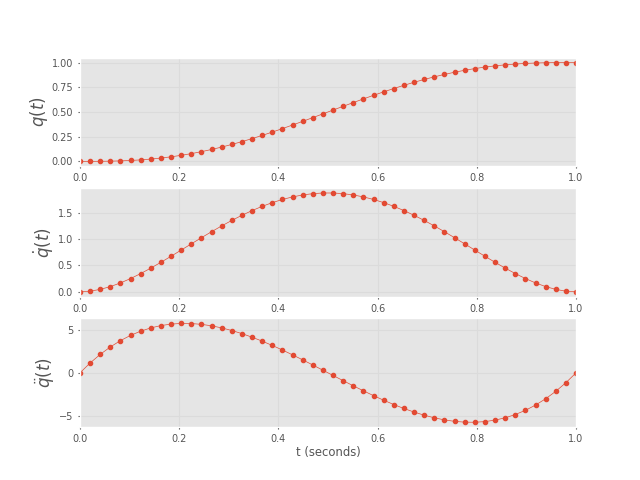

In [19]:
traj.plot();

In [20]:
quintic(0, 1, np.linspace(0, 1, 50), qd0=10, qdf=0);

In [21]:
qd = traj.qd;
qd.mean() / qd.max()

0.52310222222222

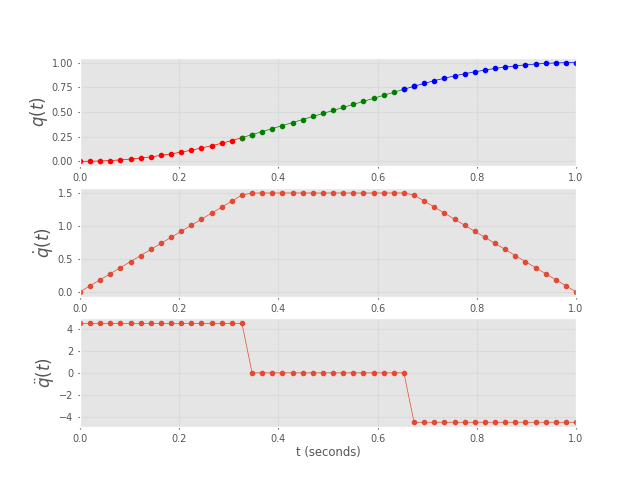

In [22]:
traj = trapezoidal(0, 1, np.linspace(0, 1, 50));
traj.plot();

In [23]:
traj.qd.max()

1.5

In [24]:
traj1_2 = trapezoidal(0, 1, np.linspace(0, 1, 50), V=1.2);
traj2_0 = trapezoidal(0, 1, np.linspace(0, 1, 50), V=2);

## 3.3.2 Multi-Axis Trajectories


In [25]:
traj = mtraj(trapezoidal, [0, 2], [1, -1], 50);

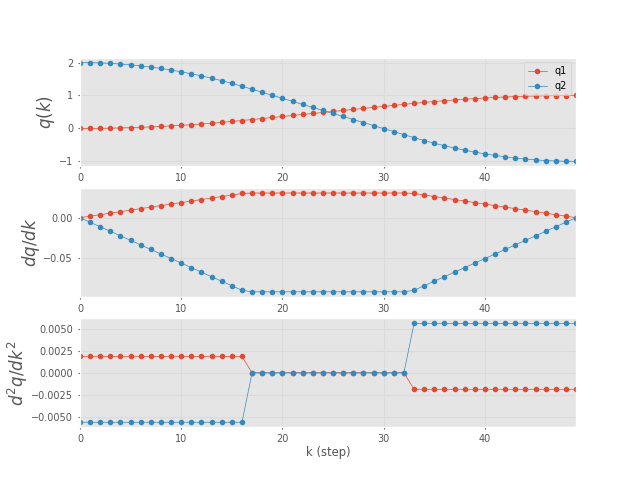

In [26]:
traj.plot();

In [27]:
T = SE3.Rand()
q = np.hstack([T.t, T.rpy()])

array([ 0.09763,   0.4304,   0.2055,    2.777,   -1.125,    1.781])

## 3.3.3 Multi-Segment Trajectories


In [28]:
via = SO2(30, unit="deg") * np.array([[-1, 1, 1, -1, -1], [1, 1, -1, -1, 1]]);
traj0 = mstraj(via.T, dt=0.2, tacc=0, qdmax=[2, 1]);

In [29]:
# xplot(traj0.q[:, 0], traj0.q[:, 1], color="red");
plt.plot(traj0.q[:, 0], traj0.q[:, 1], color="red");

In [30]:
traj2 = mstraj(via.T, dt=0.2, tacc=2, qdmax=[2, 1]);

In [31]:
len(traj0), len(traj2)

(28, 80)

## 3.3.4 Interpolation of Orientation in 3D


In [32]:
R0 = SO3.Rz(-1) * SO3.Ry(-1);
R1 = SO3.Rz(1) * SO3.Ry(1);

In [33]:
rpy0 = R0.rpy(); rpy1 = R1.rpy();

In [34]:
traj = mtraj(quintic, rpy0, rpy1, 50);

In [35]:
pose = SO3.RPY(traj.q);
len(pose)

50

In [36]:
# pose.animate()
HTML(pose.animate(movie=True, dim=1.5))

In [37]:
q0 = UnitQuaternion(R0); q1 = UnitQuaternion(R1);

In [38]:
qtraj = q0.interp(q1, 50);
len(qtraj)

50

In [39]:
# qtraj.animate()
plotvol3(new=True)  # for matplotlib/widget
HTML(qtraj.animate(movie=True, dim=1.5))

### 3.3.4.1 Direction of Rotation


In [40]:
q0 = UnitQuaternion.Rz(-2); q1 = UnitQuaternion.Rz(2);
q = q0.interp(q1, 50);
# q.animate(dim=1.])
plotvol3(new=True)  # for matplotlib/widget
HTML(q.animate(movie=True, dim=1.5))

In [41]:
q = q0.interp(q1, 50, shortest=True);
# q.animate()
plotvol3(new=True)  # for matplotlib/widget
HTML(q.animate(movie=True, dim=1.5))

## 3.3.5 Cartesian Motion in 3D


In [42]:
T0 = SE3.Trans([0.4, 0.2, 0]) * SE3.RPY(0, 0, 3);
T1 = SE3.Trans([-0.4, -0.2, 0.3]) * SE3.RPY(-pi/4, pi/4, -pi/2);

In [43]:
T0.interp(T1, 0.5)

   0.09754  -0.702     0.7055    0         
   0.702     0.551     0.4512    0         
  -0.7055    0.4512    0.5465    0.15      
   0         0         0         1         


In [44]:
Ts = T0.interp(T1, 51);

In [45]:
len(Ts)

51

In [46]:
# Ts.animate()
plotvol3(new=True)  # for matplotlib/widget
HTML(Ts.animate(movie=True, dim=1.5))

In [47]:
Ts[25]

   0.09754  -0.702     0.7055    0         
   0.702     0.551     0.4512    0         
  -0.7055    0.4512    0.5465    0.15      
   0         0         0         1         


In [48]:
P = Ts.t;
P.shape

(51, 3)

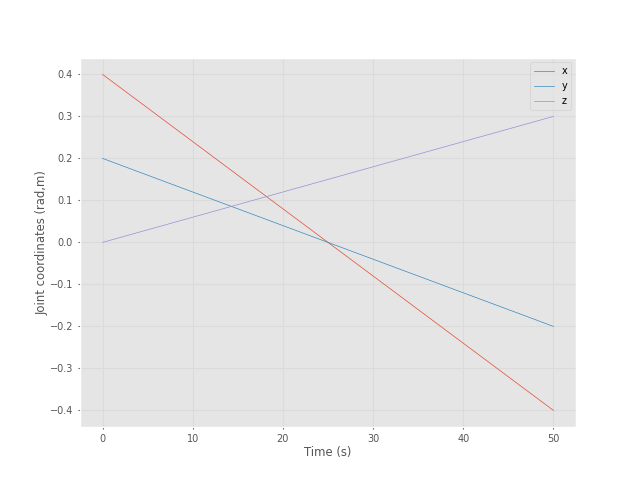

In [49]:
xplot(P, labels="x y z");

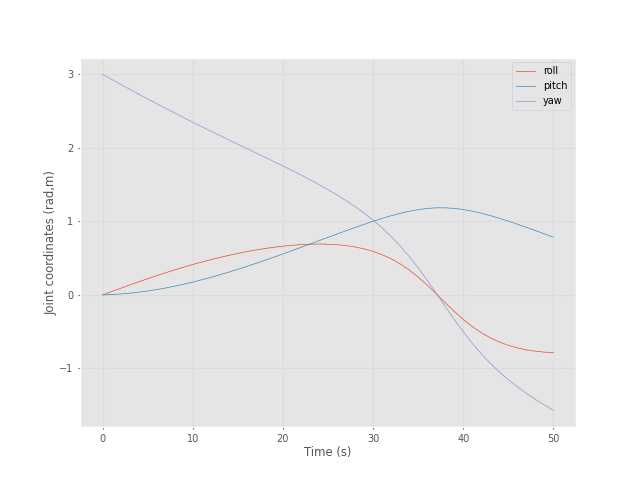

In [50]:
rpy = Ts.rpy();
xplot(rpy, labels="roll pitch yaw");

In [51]:
Ts = T0.interp(T1, trapezoidal(0, 1, 50).q);

In [52]:
Ts = ctraj(T0, T1, 50);

# 3.4 Application: Inertial Navigation


## 3.4.1 Gyroscopes


### 3.4.1.2 Estimating Orientation


In [53]:
from imu_data import IMU
true, _ = IMU()

In [54]:
orientation = UnitQuaternion();  # identity quaternion

In [55]:
for w in true.omega[:-1]:
  next = orientation[-1] @ UnitQuaternion.EulerVec(w * true.dt);
  orientation.append(next);
len(orientation)

400

In [56]:
# orientation.animate(time=true.t)
HTML(orientation.animate(time=true.t, movie=True, dim=1.5))

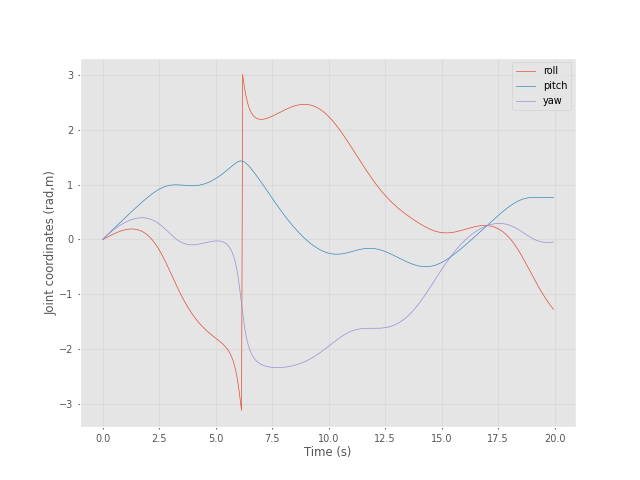

In [57]:
xplot(true.t, orientation.rpy(), labels="roll pitch yaw");

## 3.4.4 Inertial Sensor Fusion


In [58]:
from imu_data import IMU
true, imu = IMU()

In [59]:
q = UnitQuaternion();
for wm in imu.gyro[:-1]:
  q.append(q[-1] @ UnitQuaternion.EulerVec(wm * imu.dt))

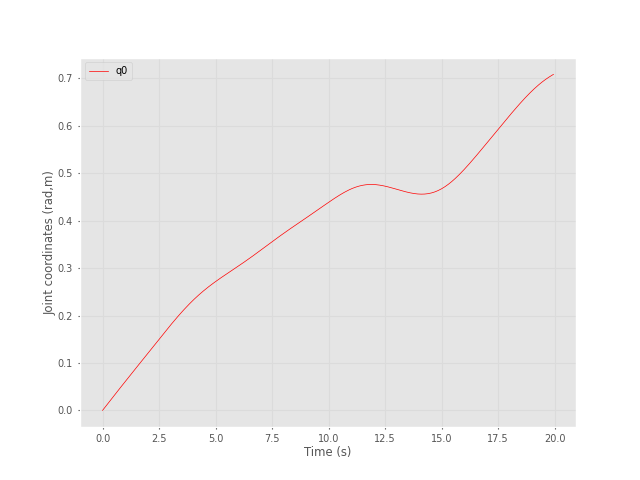

In [60]:
xplot(true.t, q.angdist(true.orientation), color="red");

In [61]:
kI = 0.2; kP = 1;
b = np.zeros(imu.gyro.shape);
qcf = UnitQuaternion();
data = zip(imu.gyro[:-1], imu.accel[:-1], imu.magno[:-1]);
for k, (wm, am, mm) in enumerate(data):
  qi = qcf[-1].inv()
  sR = np.cross(am, qi * true.g) + np.cross(mm, qi * true.B)
  wp = wm - b[k,:] + kP * sR
  qcf.append(qcf[k] @ UnitQuaternion.EulerVec(wp * imu.dt))
  b[k+1,:] = b[k,:] - kI * sR * imu.dt

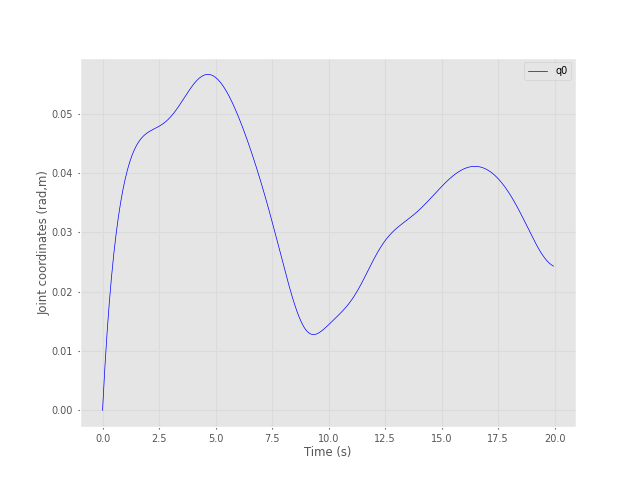

In [62]:
xplot(true.t, qcf.angdist(true.orientation), color="blue");